# Knowledge Assembly

In [1]:
from nellinetworkconjunctive import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [2]:
midd_performance, high_performers, low_performers = load_behavioural_data("./behavioural-data/")

## Set simulation mode

In [3]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"

## Set Hyperparameters

In [ ]:
# Random seeds
seeds_n = 10
mds_seed = 1

# Number of input items
items_n = 7

# Experiment details
training_blocks = 16 if mode == "two-readouts" else 8
trials = 180
training_length = 2 * training_blocks * trials
stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

learning_rate = 0.03 if mode == "lazy-regime" else 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

## Train Networks

TI Exp with conjunctive population

In [ ]:
def train_networks_exp(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

        training_step = 0
        items_per_context = items_n
        
        for block in range(training_blocks): 
            items_per_context = 7
            p = 4
            q = 2
            training_pairs_norm = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            training_pairs_exp = np.asarray([[p,q]])
            training_pairs = np.concatenate([training_pairs_norm, training_pairs_exp], axis=0)
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                if readouts == 1:
                    if item_1 == p and item_2 == q or item_1 == q and item_2 == p:
                        exception = True
                    else:
                        exception = False
                    if not exception:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    else:
                        target = torch.tensor([-1. if item_1 > item_2 else 1.])

                #UNCHANGED SO FAR
                elif readouts == 2:
                    target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])


                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                model.correct(learning_rate, gamma)
                optimiser.step()

                # Log
                with torch.no_grad():
                    results["train"]["losses"][seed, training_step] = model.loss.item()
                    results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                    results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                    results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                    results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                    results["train"]["training_progress"][seed, training_step] = model.evaluate()
                
                training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results




In [ ]:
# Train network
results = train_networks_exp(0.1)


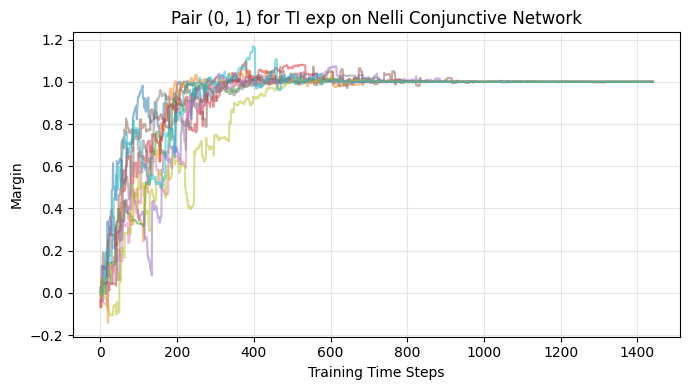

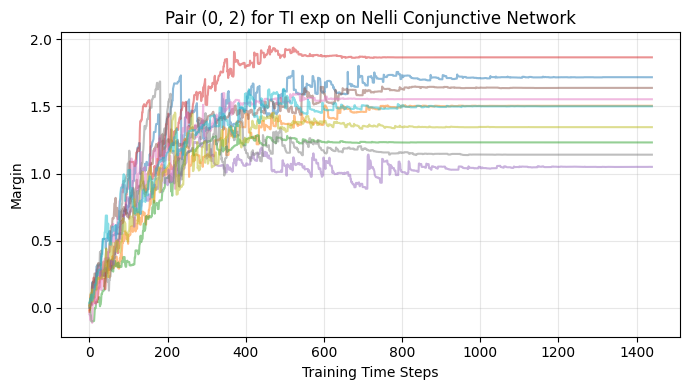

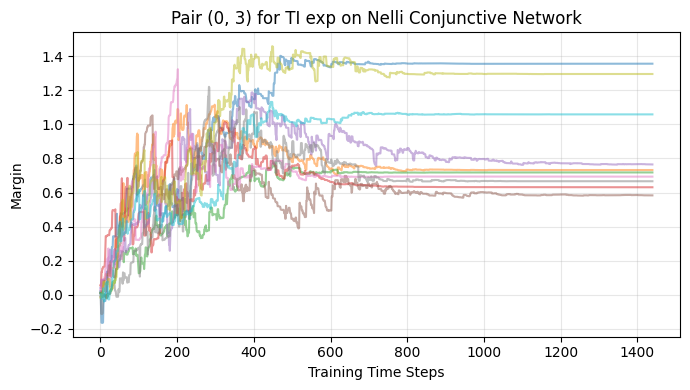

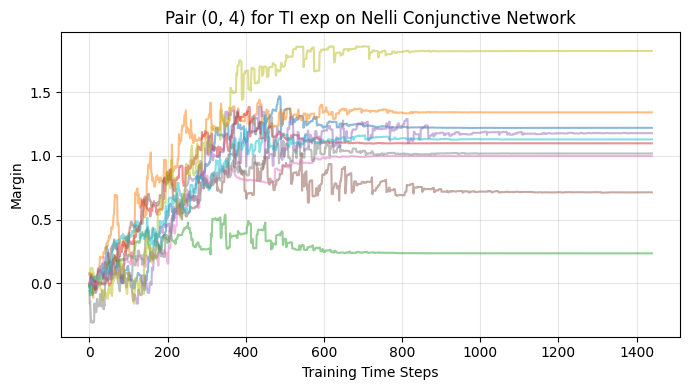

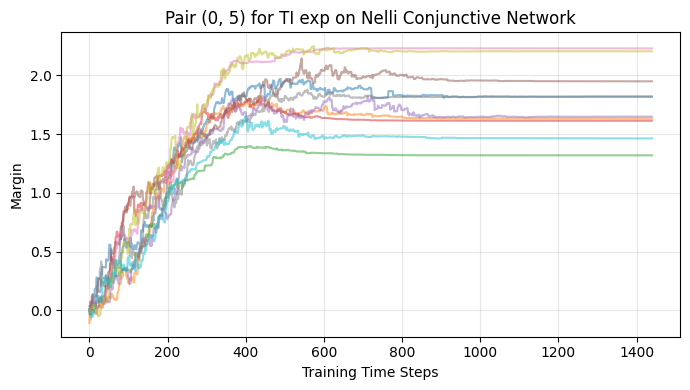

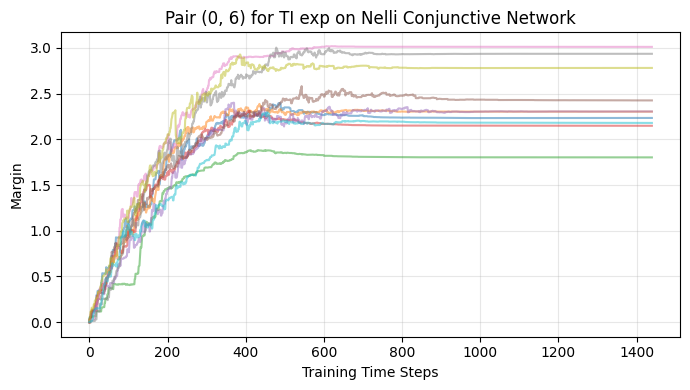

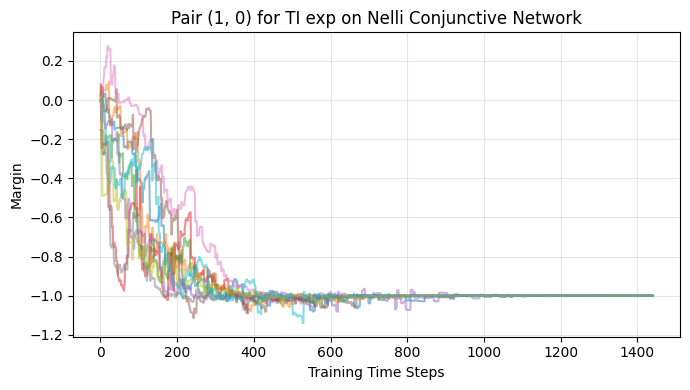

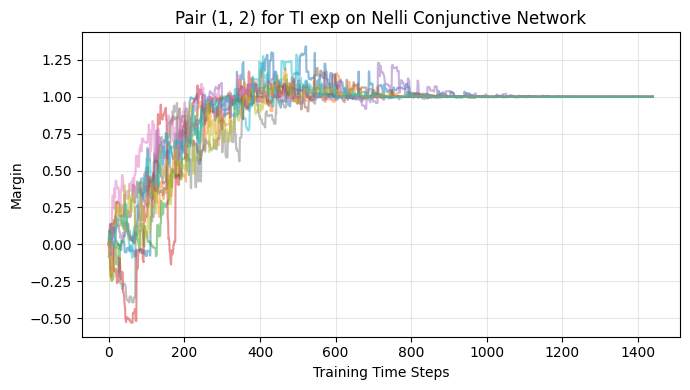

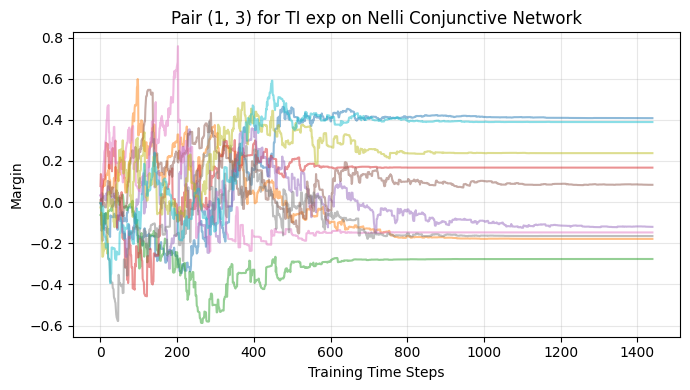

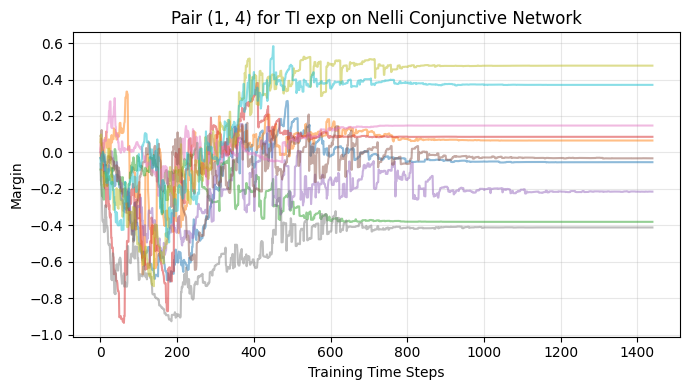

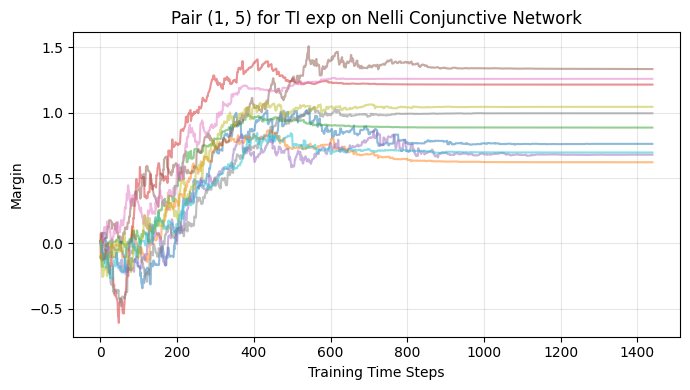

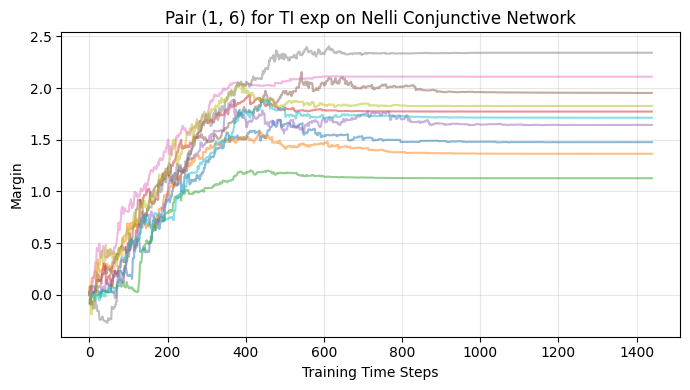

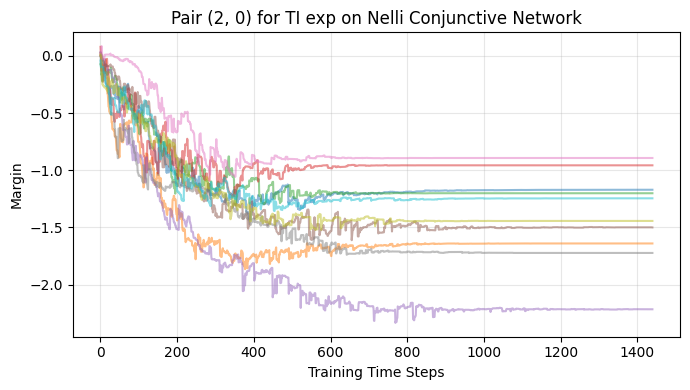

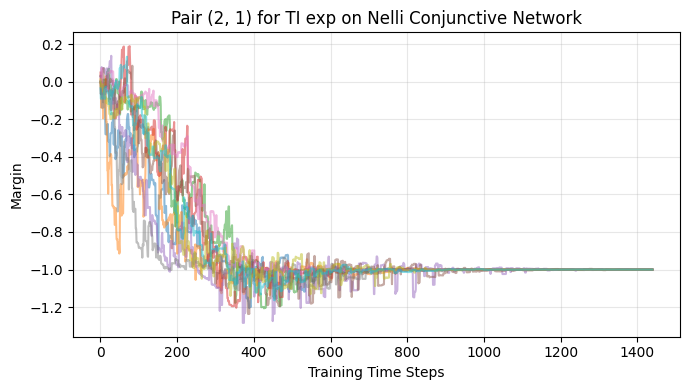

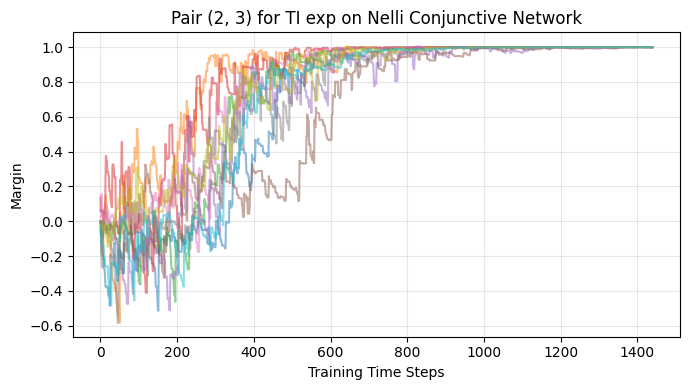

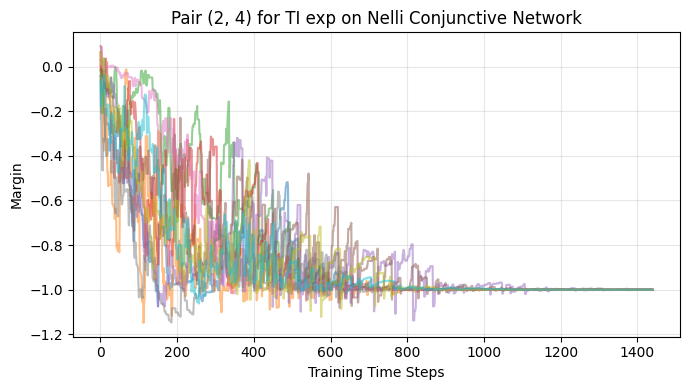

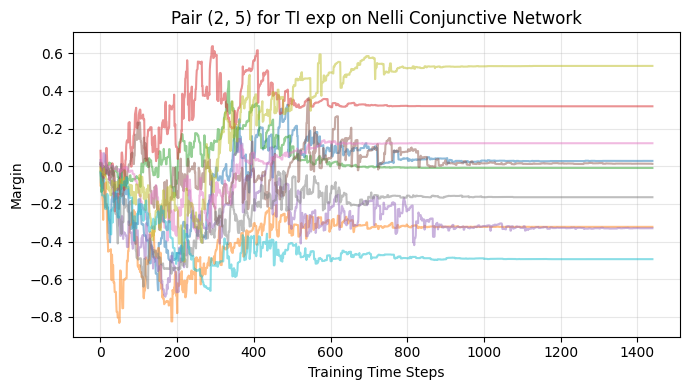

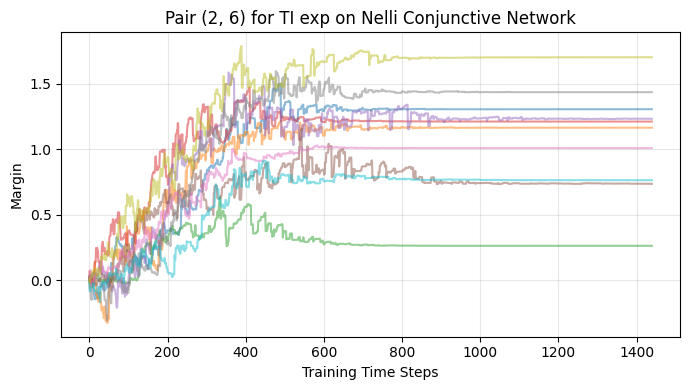

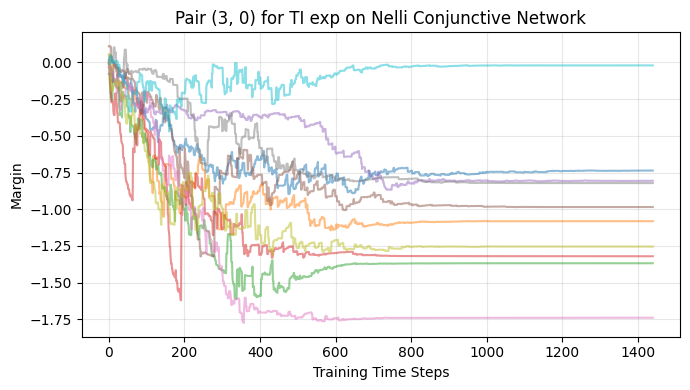

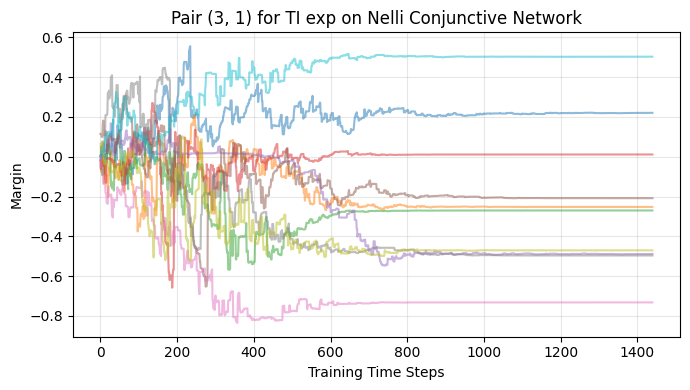

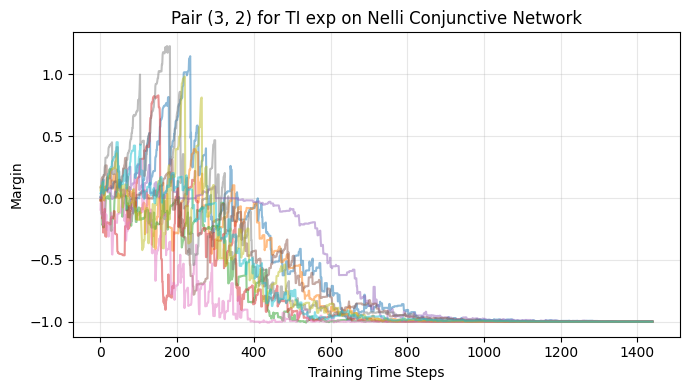

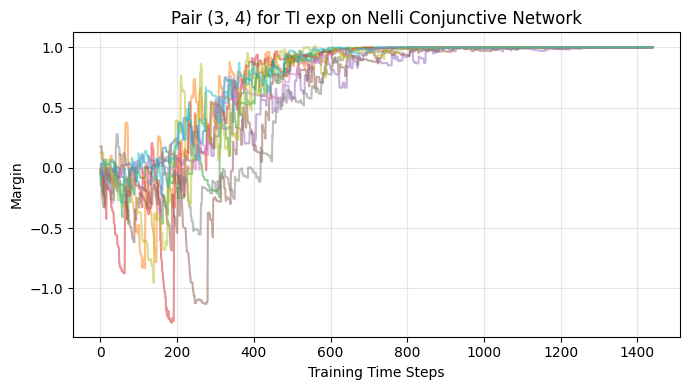

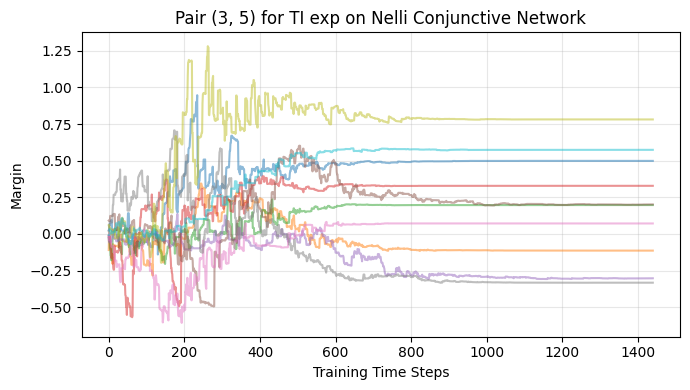

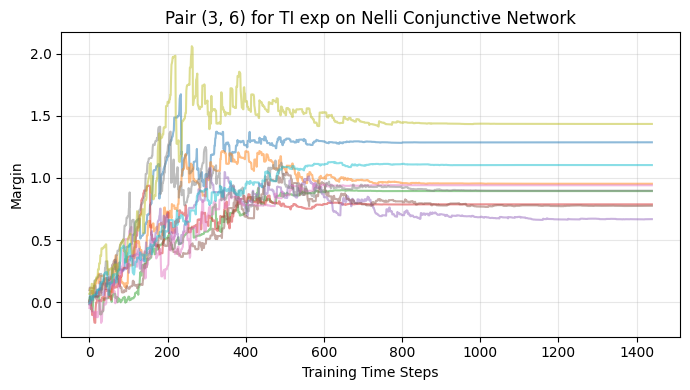

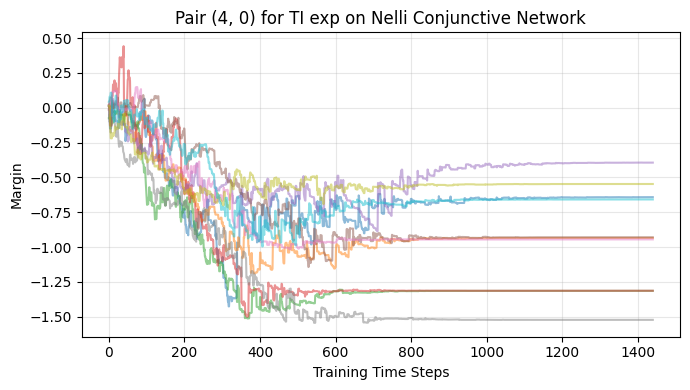

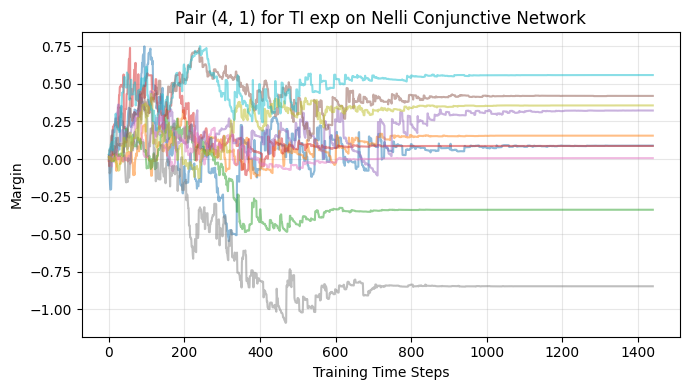

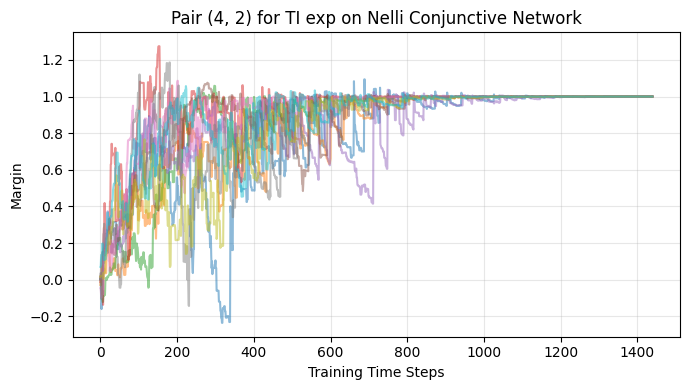

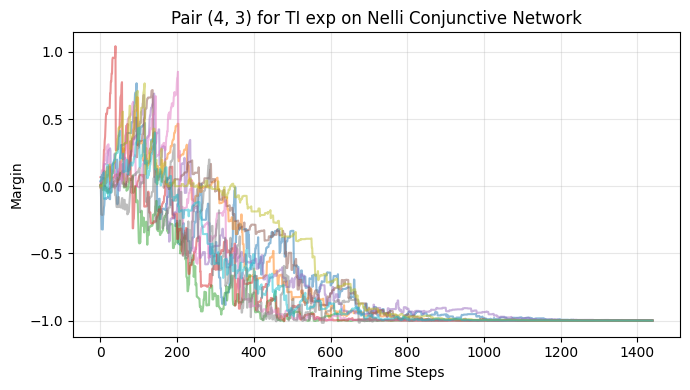

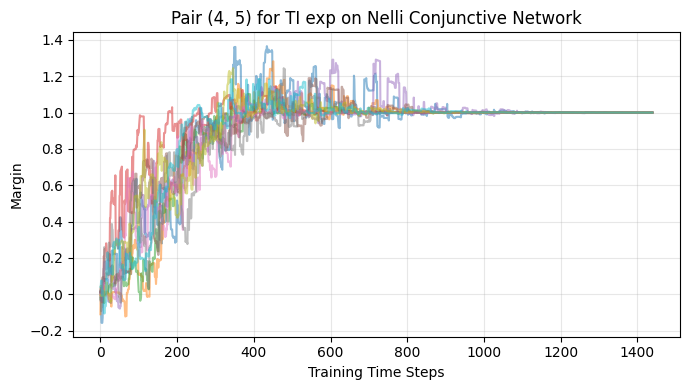

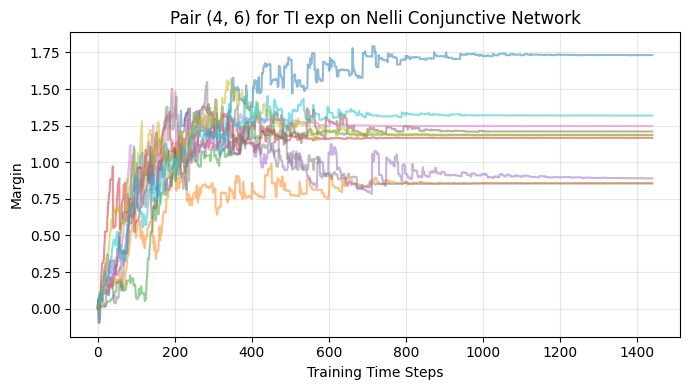

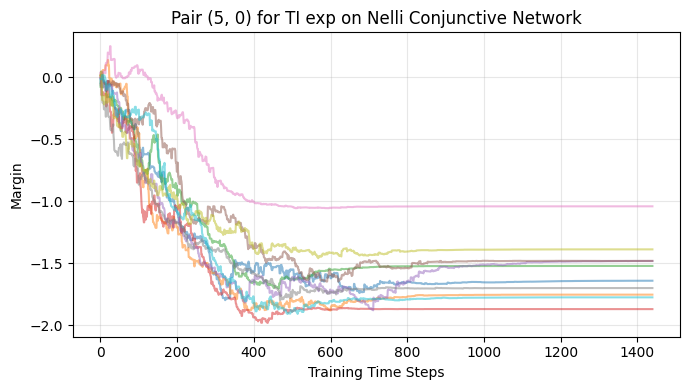

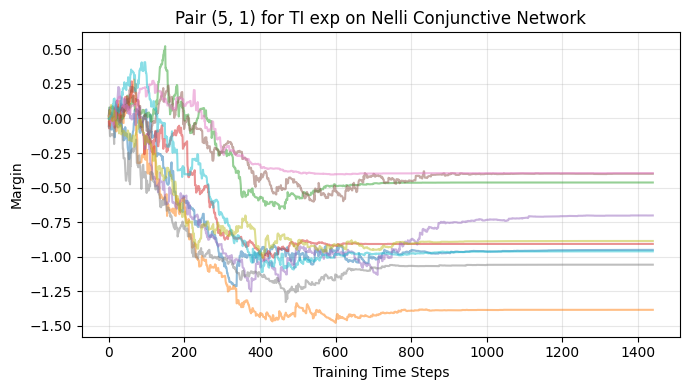

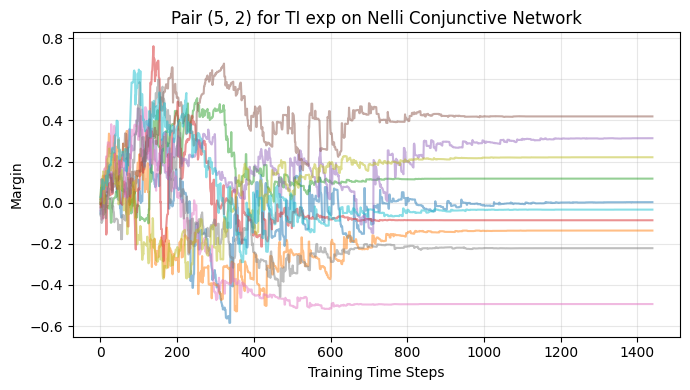

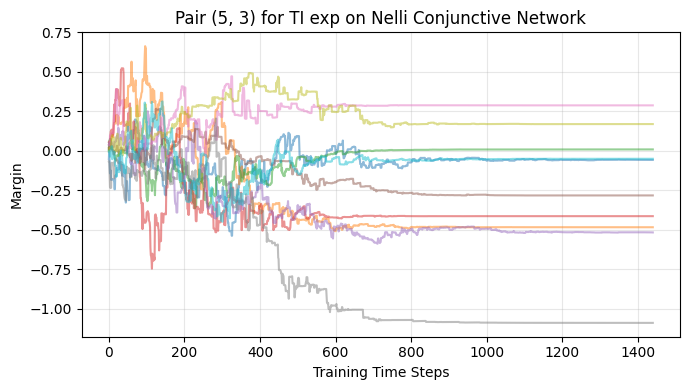

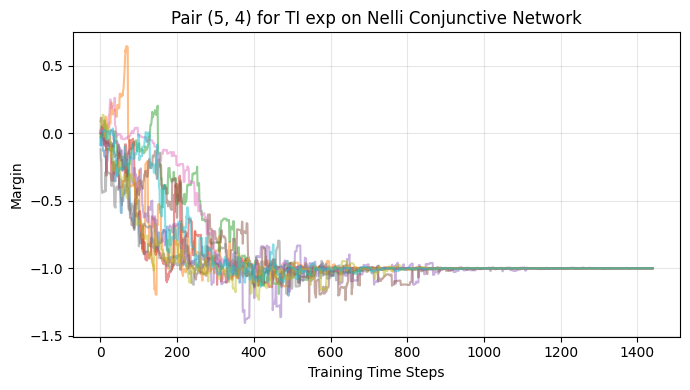

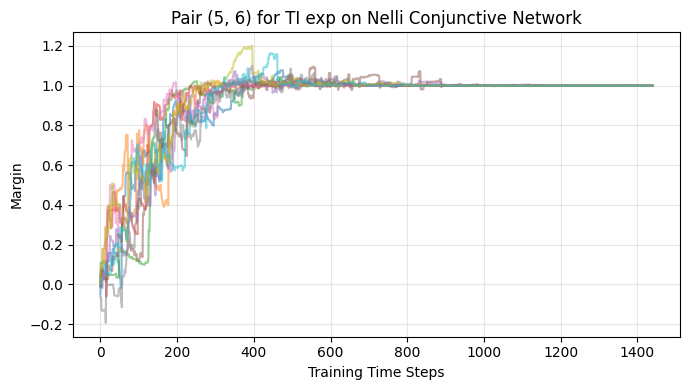

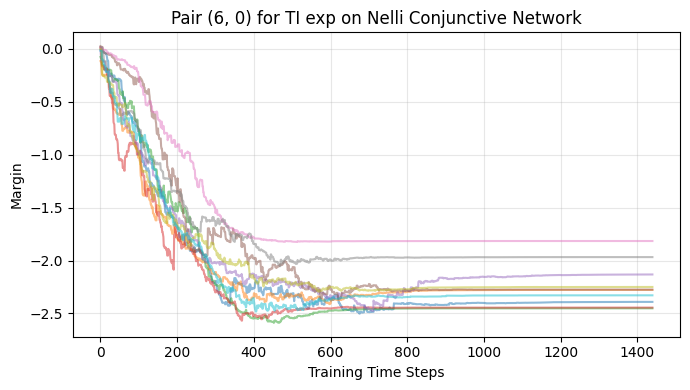

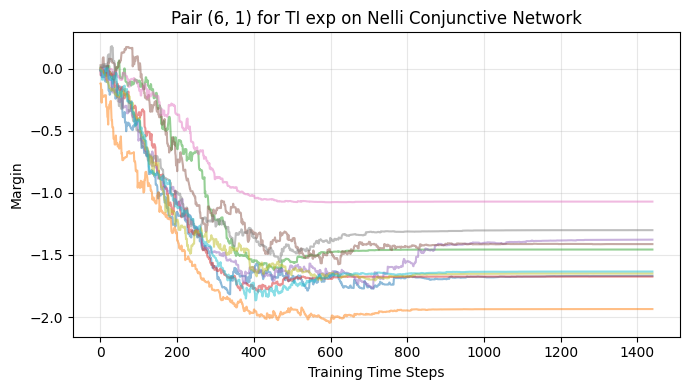

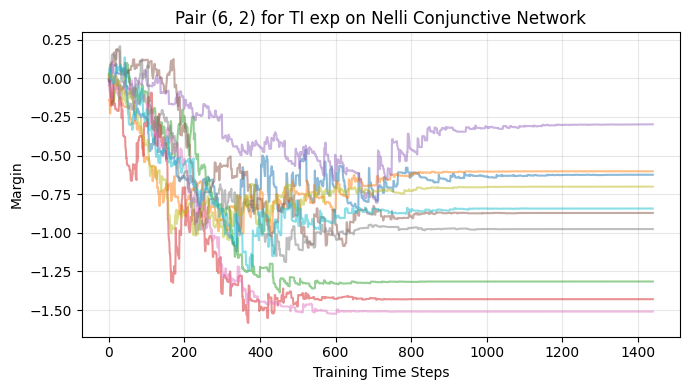

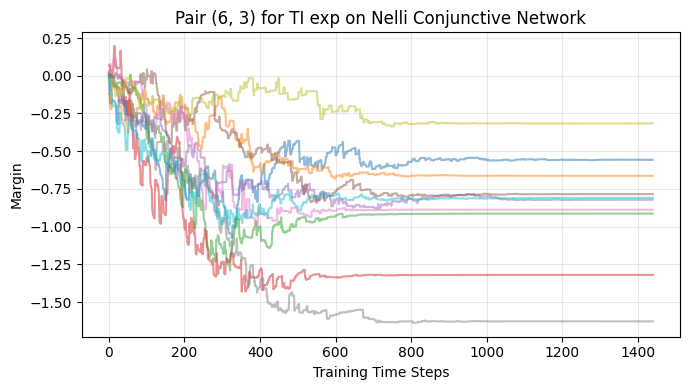

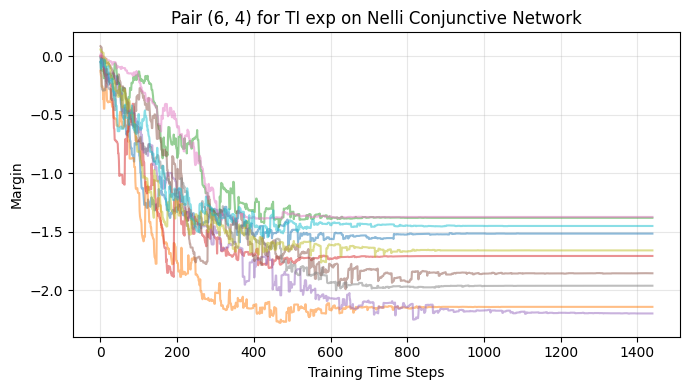

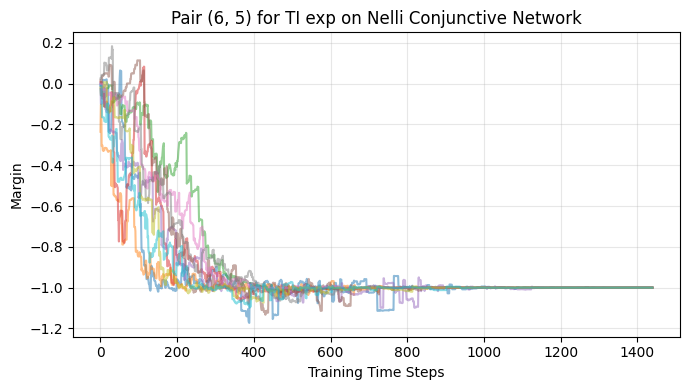

In [27]:
for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :480*3, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j}) for TI exp on Nelli Conjunctive Network")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [1]:
from csv_margin import MarginExtractor

In [ ]:
import csv

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]  # shape: (seeds_n, time_steps, items_n, items_n)
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header
header = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)

import os
ipynb_filename = os.path.abspath(__file__)
print(f"Operating in file: {ipynb_filename}")

# Write to CSV
# 'network' here refers to a variable defined earlier in the notebook, not to the class 'nellinetwork'.
csv_filename = f"{ipynb_filename}.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"Training pair results saved to {csv_filename}")

NameError: name 'results' is not defined

In [ ]:
training_length = 2880
csv_filename = f"training_pair_margins_{training_length}_nellinetworkconjunctive.csv"

import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j    seed_0    seed_1    seed_2    seed_3    seed_4  \
0          0  0  0  0.018792 -0.000755 -0.042241  0.007779 -0.007472   
1          1  0  0  0.018861 -0.000661 -0.042107  0.007718 -0.007589   
2          2  0  0  0.018710 -0.000712 -0.042191  0.015606 -0.038616   
3          3  0  0  0.018511 -0.000763 -0.042322  0.006729 -0.024446   
4          4  0  0  0.018505  0.009914 -0.074872  0.006729 -0.024226   

     seed_5    seed_6    seed_7    seed_8    seed_9  mean_margin  std_margin  
0  0.010505  0.023729 -0.001627  0.002027  0.008210     0.001895    0.017222  
1  0.010568  0.023774 -0.001668  0.002006  0.008155     0.001905    0.017205  
2  0.010608  0.023695 -0.001715  0.002047  0.008343    -0.000423    0.021481  
3  0.010687  0.023736 -0.001867 -0.067648  0.008446    -0.006894    0.027624  
4  0.010525  0.023543 -0.001996 -0.124378  0.008303    -0.014795    0.045495  


Figure out keyerror on t issue

In [8]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'mean_margin', 'std_margin']


In [ ]:
import matplotlib.pyplot as plt

items_per_context = 7
p = 4
q = 2w
n = items_n

Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, 480, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

Display_Grid = Average_Grid.copy()
Display_Grid[2,4] *= -1
Display_Grid[4,2] *= -1

plt.figure(figsize=(8, 6))
plt.imshow(Display_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid (exceptions flipped) for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square, using Display_Grid for values
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Display_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Display_Grid[i, j] < (Display_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


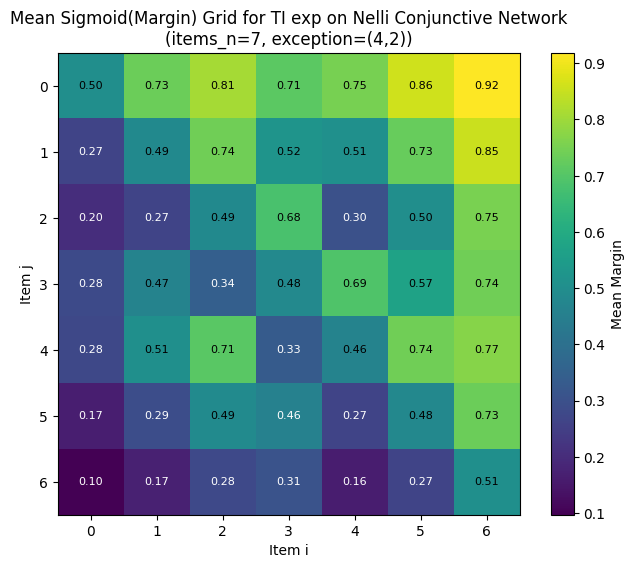

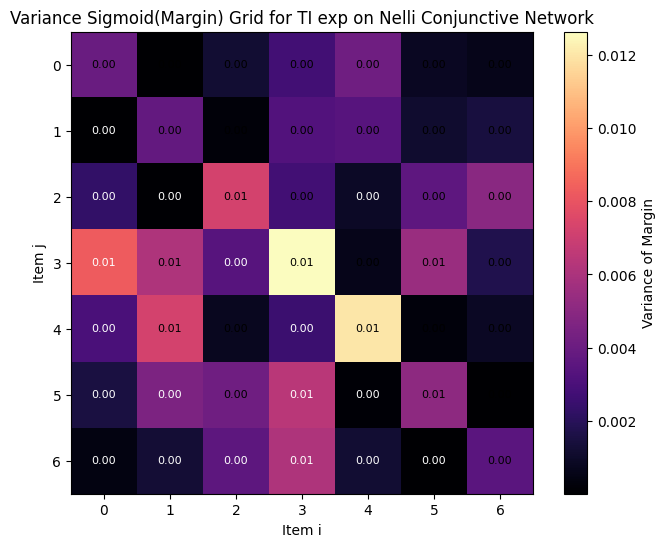

In [25]:
# if isinstance(results, tuple):
    # results = results[1]
# training_progress = results["train"]["training_progress"]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, 480, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()